In [16]:
#Imports and libraries

import pandas as pd
import numpy as np
from numpy import linalg
import random as rand
import csv
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from sklearn import preprocessing
import collections
import math
import statistics

import sys  
sys.path.insert(0, '../scripts')
import krippendorff_alpha
import bootstrap_workers

sys.path.insert(0, '../scripts/xrr')
from xrr.xrr_class import xRR

import warnings
warnings.filterwarnings('ignore')

# Process experiment files and compute stats

In [2]:
#Read the data of the experiment
# To replicate the analysis, replace the LINK_TO_SOURCE_FILE with the source file

link = '../data/LINK_TO_SOURCE_FILE'
experiment = pd.read_csv(link)

repetition1 = experiment[(experiment["Experiment"] == "E1") & (experiment["Dataset"] == "Dataset 2") & (experiment["Week"] == 1)]
repetition2 = experiment[(experiment["Experiment"] == "E1") & (experiment["Dataset"] == "Dataset 2") & (experiment["Week"] == 2)]
repetition3 = experiment[(experiment["Experiment"] == "E1") & (experiment["Dataset"] == "Dataset 2") & (experiment["Week"] == 3)]
repetition4 = experiment[(experiment["Experiment"] == "E1") & (experiment["Dataset"] == "Dataset 2") & (experiment["Week"] == 4)]
repetition5 = experiment[(experiment["Experiment"] == "E1") & (experiment["Dataset"] == "Dataset 2") & (experiment["Week"] == 5)]

In [3]:
#Get rater ids and the total number of raters per repetition

raterIds1 = list(set(list(repetition1["WorkerId"])))
raterIds2 = list(set(list(repetition2["WorkerId"])))
raterIds3 = list(set(list(repetition3["WorkerId"])))
raterIds4 = list(set(list(repetition4["WorkerId"])))
raterIds5 = list(set(list(repetition5["WorkerId"])))

print("Number of raters in Repetition 1: ", len(raterIds1))
print("Number of raters in Repetition 2: ", len(raterIds2))
print("Number of raters in Repetition 3: ", len(raterIds3))
print("Number of raters in Repetition 4: ", len(raterIds4))
print("Number of raters in Repetition 5: ", len(raterIds5))

Number of raters in Repetition 1:  109
Number of raters in Repetition 2:  112
Number of raters in Repetition 3:  106
Number of raters in Repetition 4:  96
Number of raters in Repetition 5:  105


In [4]:
#@title Process the results of all repetitions and compute stats

import statistics as sts

repetitions = []

classes = {"Fit+aspect" : 1,
           "No+issue+with+size+or+fit" : 2,
           "Size+aspect" : 3}

def process_judgments(repetition, repetitions, rep_index):
    for i in range(len(repetition)):
        docs = repetition["Answer.serialized_field"].iloc[i].split("&")
        index = 1
        for doc in docs:
            annotation = []
            annotation.append(index)
            annotation.append(rep_index)
            annotation.append(repetition["WorkerId"].iloc[i])
            annotation.append(classes[doc.split("=")[1]])

            for cl in classes:
                if doc.split("=")[1] == cl:
                    annotation.append(1)
                else: 
                    annotation.append(0)

            repetitions.append(annotation)
            index += 1
    return repetitions

repetitions = []
repetitions = process_judgments(repetition1, repetitions, "Repetition 1")
repetitions = process_judgments(repetition2, repetitions, "Repetition 2")
repetitions = process_judgments(repetition3, repetitions, "Repetition 3")
repetitions = process_judgments(repetition4, repetitions, "Repetition 4")
repetitions = process_judgments(repetition5, repetitions, "Repetition 5")


columns = ["ItemId", "Repetition", "Rater", "Classification", "Fit+aspect",
           "No+issue+with+size+or+fit", "Size+aspect"]
datadf = pd.DataFrame(repetitions, columns = columns)
datadf.to_csv("../data/PR_cleaned_dataset.csv", index=False)

In [6]:
datadf.head(5)

,ItemId,Repetition,Rater,Classification,Fit+aspect,No+issue+with+size+or+fit,Size+aspect
0,1,Repetition 1,2523,1,1,0,0
1,2,Repetition 1,2523,1,1,0,0
2,3,Repetition 1,2523,2,0,1,0
3,4,Repetition 1,2523,2,0,1,0
4,5,Repetition 1,2523,3,0,0,1


# Agreement Analysis

In [7]:
# Compute the IRR score of the experiment
repetition1 = datadf[datadf["Repetition"] == "Repetition 1"]
repetition2 = datadf[datadf["Repetition"] == "Repetition 2"]
repetition3 = datadf[datadf["Repetition"] == "Repetition 3"]
repetition4 = datadf[datadf["Repetition"] == "Repetition 4"]
repetition5 = datadf[datadf["Repetition"] == "Repetition 5"]

def compute_dataset_agreement(repetition, answer_column, repetition_index):
    data = [list(repetition[answer_column])[i * 20:(i + 1) * 20] for i in range((len(list(repetition[answer_column])) + 20 - 1) // 20 )]
    missing = "*"
    kappa = krippendorff_alpha.krippendorff_alpha(data, metric=krippendorff_alpha.nominal_metric, missing_items=missing)
    print("Krippendorff's alpha for", repetition_index, ": ", round(kappa, 4))

compute_dataset_agreement(repetition1, "Classification", "Repetition 1")
compute_dataset_agreement(repetition2, "Classification", "Repetition 2")
compute_dataset_agreement(repetition3, "Classification", "Repetition 3")
compute_dataset_agreement(repetition4, "Classification", "Repetition 4")
compute_dataset_agreement(repetition5, "Classification", "Repetition 5")

Krippendorff's alpha for Repetition 1 :  0.4059
Krippendorff's alpha for Repetition 2 :  0.3296
Krippendorff's alpha for Repetition 3 :  0.3172
Krippendorff's alpha for Repetition 4 :  0.2047
Krippendorff's alpha for Repetition 5 :  0.3612


In [8]:
# Compute the IRR score for each possible answer and in each experiment
classifs = ["Fit+aspect", "No+issue+with+size+or+fit", "Size+aspect"]

def compute_agrm_per_class(repetition):
    data = [list(repetition[cls])[i * 20:(i + 1) * 20] for i in range((len(list(repetition[cls])) + 20 - 1) // 20 )]
    missing = "*"
    alpha = krippendorff_alpha.krippendorff_alpha(data, metric=krippendorff_alpha.nominal_metric, missing_items=missing)
    return alpha

for cls in classifs:
    print(cls)
    
    alpha = compute_agrm_per_class(repetition1)
    print("Krippendorff's alpha for Repetition 1:", round(alpha, 4))

    alpha = compute_agrm_per_class(repetition2)
    print("Krippendorff's alpha for Repetition 2:", round(alpha, 4))

    alpha = compute_agrm_per_class(repetition3)
    print("Krippendorff's alpha for Repetition 3:", round(alpha, 4))

    alpha = compute_agrm_per_class(repetition4)
    print("Krippendorff's alpha for Repetition 4:", round(alpha, 4))

    alpha = compute_agrm_per_class(repetition5)
    print("Krippendorff's alpha for Repetition 5:", round(alpha, 4))

Fit+aspect
Krippendorff's alpha for Repetition 1: 0.2415
Krippendorff's alpha for Repetition 2: 0.1747
Krippendorff's alpha for Repetition 3: 0.2042
Krippendorff's alpha for Repetition 4: 0.1095
Krippendorff's alpha for Repetition 5: 0.2225
No+issue+with+size+or+fit
Krippendorff's alpha for Repetition 1: 0.4401
Krippendorff's alpha for Repetition 2: 0.3723
Krippendorff's alpha for Repetition 3: 0.3543
Krippendorff's alpha for Repetition 4: 0.2434
Krippendorff's alpha for Repetition 5: 0.41
Size+aspect
Krippendorff's alpha for Repetition 1: 0.5134
Krippendorff's alpha for Repetition 2: 0.4279
Krippendorff's alpha for Repetition 3: 0.3851
Krippendorff's alpha for Repetition 4: 0.2455
Krippendorff's alpha for Repetition 5: 0.4285


# Precision Analysis

In [9]:
def iqv_metric(elems, total):
    pct = 0
    for elem in elems:
        pct += ((elem * 100)/total) ** 2

    iqv = (len(elems) * (10000 - pct)) / (10000 * (len(elems) - 1))
    return iqv

def majority_answer(df, column_name, pos_val):
    counts = []
    for elem in pos_val:
        counts.append(list(df[column_name]).count(elem))
    return counts

def compute_stats_per_item(item_id, repetition, item_column, pos_val, column_name):
    subset = repetition[repetition[item_column] == unit]
    maj_ans = majority_answer(subset, column_name, pos_val)
    
    return maj_ans.index(max(maj_ans)) + 1
    

units = list(set(datadf["ItemId"]))
pos_val = [1,2,3,4,]
columns = ["item_id", "Repetition 1", "Repetition 2", "Repetition 3", "Repetition 4", "Repetition 5", "IQV 1", "IQV 2", "IQV 3", "IQV 4", "IQV 5"]

rows = []
for unit in units:
    row = [unit]
    maj_answer1 = compute_stats_per_item(unit, repetition1, "ItemId", pos_val, "Classification")
    maj_answer2 = compute_stats_per_item(unit, repetition2, "ItemId", pos_val, "Classification")
    maj_answer3 = compute_stats_per_item(unit, repetition3, "ItemId", pos_val, "Classification")
    maj_answer4 = compute_stats_per_item(unit, repetition4, "ItemId", pos_val, "Classification")
    maj_answer5 = compute_stats_per_item(unit, repetition5, "ItemId", pos_val, "Classification")
    
    row.extend([maj_answer1, maj_answer2, maj_answer3, maj_answer4, maj_answer5])
    
    subset1 = repetition1[repetition1["ItemId"] == unit]
    subset2 = repetition2[repetition2["ItemId"] == unit]
    subset3 = repetition3[repetition3["ItemId"] == unit]
    subset4 = repetition4[repetition4["ItemId"] == unit]
    subset5 = repetition5[repetition5["ItemId"] == unit]
    
    iqv1 = iqv_metric(majority_answer(subset1, "Classification", pos_val), len(subset1))
    iqv2 = iqv_metric(majority_answer(subset2, "Classification", pos_val), len(subset2))
    iqv3 = iqv_metric(majority_answer(subset3, "Classification", pos_val), len(subset3))
    iqv4 = iqv_metric(majority_answer(subset4, "Classification", pos_val), len(subset4))
    iqv5 = iqv_metric(majority_answer(subset5, "Classification", pos_val), len(subset5))

    row.extend([round(iqv1, 4), round(iqv2, 4), round(iqv3, 4), round(iqv4, 4), round(iqv5, 4)])
    rows.append(row) 

precision_df = pd.DataFrame(rows, columns = columns)

In [11]:
precision_df

,item_id,Repetition 1,Repetition 2,Repetition 3,Repetition 4,Repetition 5,IQV 1,IQV 2,IQV 3,IQV 4,IQV 5
0,1,2,1,1,2,1,0.8610,0.9021,0.9252,0.9704,0.8691
1,2,1,1,1,1,1,0.7489,0.7395,0.7423,0.8688,0.8180
2,3,2,2,2,2,2,0.2793,0.3614,0.5449,0.6279,0.3820
3,4,2,2,2,2,2,0.3878,0.4762,0.5190,0.6090,0.3124
4,5,3,3,3,3,3,0.1818,0.3599,0.4422,0.5244,0.3810
5,6,1,2,1,2,1,0.8004,0.8124,0.8418,0.9020,0.8302
6,7,2,2,2,2,2,0.3252,0.4833,0.4859,0.5895,0.4479
7,8,2,2,2,2,2,0.4300,0.5742,0.5423,0.6784,0.3597
8,9,3,3,3,3,3,0.7714,0.7474,0.8010,0.8760,0.7703
9,10,1,1,1,1,1,0.7570,0.8287,0.7575,0.9059,0.7859


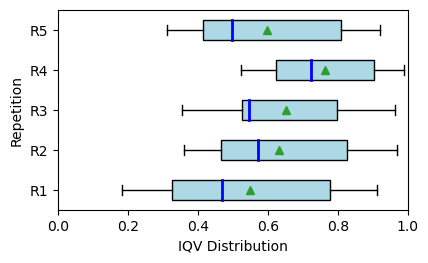

In [13]:
import matplotlib.pyplot as plt
import numpy as np
 
 
# Creating dataset
np.random.seed(10)

data = [precision_df["IQV 1"], precision_df["IQV 2"], precision_df["IQV 3"], precision_df["IQV 4"], precision_df["IQV 5"]]
 
fig = plt.figure(figsize =(3.5, 2))
plt.rcParams['axes.grid'] = False
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data, patch_artist = True, vert = 0, showmeans=True)

for patch in bp['boxes']:
    patch.set_facecolor("lightblue")

for mean in bp['means']:
    mean.set_color("blue") 

for median in bp['medians']:
    median.set(color ='blue', linewidth = 2)

ax.set_yticklabels(['R1', 'R2', 'R3', 'R4', 'R5'])
ax.set_xlim(0, 1)
ax.set_xlabel("IQV Distribution")
ax.set_ylabel("Repetition")
# show plot
fig.show()
fig.savefig("../plots/pr_iqv.png", bbox_inches='tight', format="png", dpi=1200)

# Stability Analysis

In [14]:
from scipy import stats
from itertools import combinations

repetitions = ["Repetition 1", "Repetition 2", "Repetition 3", "Repetition 4", "Repetition 5"]
combs = list(combinations(repetitions, 2))
for comb in combs:
    crosstab = pd.crosstab(precision_df[comb[0]], precision_df[comb[1]])
    print(comb[0], " vs. ", comb[1], ":", stats.chi2_contingency(crosstab))

Repetition 1  vs.  Repetition 2 : (24.866666666666667, 5.351256065347801e-05, 4, array([[1.25, 2.25, 1.5 ],
       [2.5 , 4.5 , 3.  ],
       [1.25, 2.25, 1.5 ]]))
Repetition 1  vs.  Repetition 3 : (35.0, 4.6453484381263683e-07, 4, array([[1.5 , 2.25, 1.25],
       [3.  , 4.5 , 2.5 ],
       [1.5 , 2.25, 1.25]]))
Repetition 1  vs.  Repetition 4 : (34.54545454545455, 5.759081576623961e-07, 4, array([[1.  , 2.75, 1.25],
       [2.  , 5.5 , 2.5 ],
       [1.  , 2.75, 1.25]]))
Repetition 1  vs.  Repetition 5 : (29.799999999999997, 5.37538213940854e-06, 4, array([[1.25, 2.5 , 1.25],
       [2.5 , 5.  , 2.5 ],
       [1.25, 2.5 , 1.25]]))
Repetition 2  vs.  Repetition 3 : (29.876543209876544, 5.185997417806884e-06, 4, array([[1.5 , 2.25, 1.25],
       [2.7 , 4.05, 2.25],
       [1.8 , 2.7 , 1.5 ]]))
Repetition 2  vs.  Repetition 4 : (29.696969696969695, 5.64121581367049e-06, 4, array([[1.  , 2.75, 1.25],
       [1.8 , 4.95, 2.25],
       [1.2 , 3.3 , 1.5 ]]))
Repetition 2  vs.  Repetition 5 

# Replicability Analysis

In [17]:
repetition1.name = "Repetition 1"
repetition2.name = "Repetition 2"
repetition3.name = "Repetition 3"
repetition4.name = "Repetition 4"
repetition5.name = "Repetition 5"

combs = combinations([repetition1, repetition2, repetition3, repetition4, repetition5], 2)

xRR_matrix = np.ones((5, 5), dtype = float)

for comb in list(combs):
    xRR_object = xRR(comb[0], comb[1], "Classification", "Rater", "ItemId")
    print("xRR score between " + comb[0].name + " and " + comb[1].name + " is:", xRR_object.kappa_x())
    xRR_matrix[int(comb[1].name[-1]) - 1, int(comb[0].name[-1]) - 1] = xRR_object.kappa_x()
                
print(xRR_matrix)

21/08/2023 17:41:40  observed disagreement: 0.3966169724771007
21/08/2023 17:41:40  expected disagreement: 0.6278380979685452


xRR score between Repetition 1 and Repetition 2 is: 0.3682814506472156


21/08/2023 17:41:40  observed disagreement: 0.40580751254973846
21/08/2023 17:41:41  expected disagreement: 0.6345425826553575


xRR score between Repetition 1 and Repetition 3 is: 0.36047237231650553


21/08/2023 17:41:41  observed disagreement: 0.45202599388377374
21/08/2023 17:41:41  expected disagreement: 0.6363904816513761


xRR score between Repetition 1 and Repetition 4 is: 0.28970340236578196


21/08/2023 17:41:42  observed disagreement: 0.38499344692003185
21/08/2023 17:41:42  expected disagreement: 0.6253176059414591


xRR score between Repetition 1 and Repetition 5 is: 0.38432335302570375


21/08/2023 17:41:42  observed disagreement: 0.4308246293800728
21/08/2023 17:41:42  expected disagreement: 0.6384046495956873


xRR score between Repetition 2 and Repetition 3 is: 0.32515430510582666


21/08/2023 17:41:43  observed disagreement: 0.47305617559527785
21/08/2023 17:41:43  expected disagreement: 0.6406089564732143


xRR score between Repetition 2 and Repetition 4 is: 0.26155235449778214


21/08/2023 17:41:43  observed disagreement: 0.4121130952381199
21/08/2023 17:41:43  expected disagreement: 0.630704506802721


xRR score between Repetition 2 and Repetition 5 is: 0.34658292307553573


21/08/2023 17:41:44  observed disagreement: 0.48046874999996014
21/08/2023 17:41:44  expected disagreement: 0.6452166863207547


xRR score between Repetition 3 and Repetition 4 is: 0.25533737706047777


21/08/2023 17:41:44  observed disagreement: 0.42067834681045996
21/08/2023 17:41:44  expected disagreement: 0.6369047619047619


xRR score between Repetition 3 and Repetition 5 is: 0.339495679774231


21/08/2023 17:41:45  observed disagreement: 0.46462797619044505
21/08/2023 17:41:45  expected disagreement: 0.6386636904761904


xRR score between Repetition 4 and Repetition 5 is: 0.27249977864873387
[[1.         1.         1.         1.         1.        ]
 [0.36828145 1.         1.         1.         1.        ]
 [0.36047237 0.32515431 1.         1.         1.        ]
 [0.2897034  0.26155235 0.25533738 1.         1.        ]
 [0.38432335 0.34658292 0.33949568 0.27249978 1.        ]]


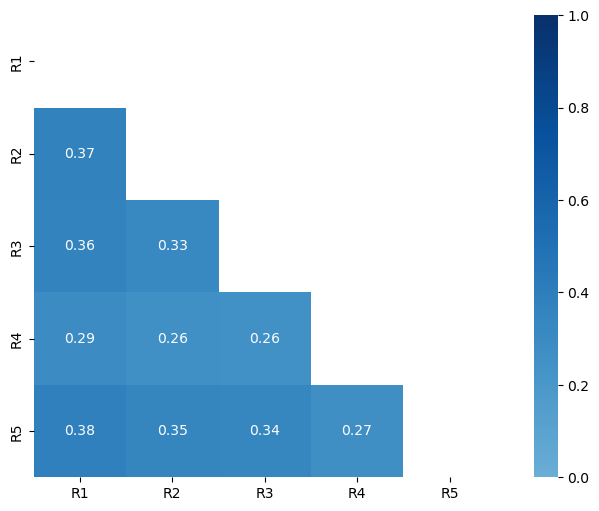

In [18]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

columns = ["R1", "R2", "R3", "R4", "R5"]

df_data = pd.DataFrame(xRR_matrix, columns = columns)

# Create a mask
mask = np.triu(np.ones_like(df_data, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(df_data, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap="Blues", yticklabels=["R1", "R2", "R3", "R4", "R5"], 
            vmin=0.0, vmax=1.0)

plt.savefig("../plots/xRR_PR.png",  bbox_inches='tight', format='png', dpi=1200)
plt.show()


Fit+aspect


21/08/2023 17:42:28  observed disagreement: 0.2924189056356683
21/08/2023 17:42:28  expected disagreement: 0.3698660714285714
21/08/2023 17:42:29  observed disagreement: 0.29376839189889425
21/08/2023 17:42:29  expected disagreement: 0.37940366972477063
21/08/2023 17:42:29  observed disagreement: 0.30865347859326026
21/08/2023 17:42:29  expected disagreement: 0.3687915711009174
21/08/2023 17:42:29  observed disagreement: 0.2773394495412737
21/08/2023 17:42:30  expected disagreement: 0.36144517256443864
21/08/2023 17:42:30  observed disagreement: 0.31519541778977206
21/08/2023 17:42:30  expected disagreement: 0.39028386118598385
21/08/2023 17:42:30  observed disagreement: 0.32728794642859077
21/08/2023 17:42:31  expected disagreement: 0.38062918526785716
21/08/2023 17:42:31  observed disagreement: 0.2991454081632827
21/08/2023 17:42:31  expected disagreement: 0.37394557823129254
21/08/2023 17:42:31  observed disagreement: 0.3309944968553354
21/08/2023 17:42:32  expected disagreement: 0.

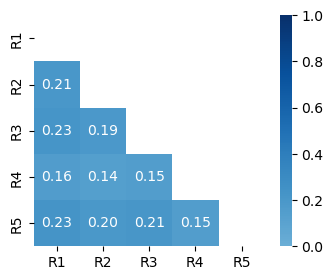

No+issue+with+size+or+fit


21/08/2023 17:42:33  observed disagreement: 0.2967562254259704
21/08/2023 17:42:33  expected disagreement: 0.5001621887287024
21/08/2023 17:42:33  observed disagreement: 0.3022416479141233
21/08/2023 17:42:34  expected disagreement: 0.5004189025445733
21/08/2023 17:42:34  observed disagreement: 0.3356699159021275
21/08/2023 17:42:34  expected disagreement: 0.5005203555045872
21/08/2023 17:42:34  observed disagreement: 0.28689820882480094
21/08/2023 17:42:35  expected disagreement: 0.5000768894713848
21/08/2023 17:42:35  observed disagreement: 0.3166357816711739
21/08/2023 17:42:35  expected disagreement: 0.4986657681940701
21/08/2023 17:42:35  observed disagreement: 0.3471819196428803
21/08/2023 17:42:36  expected disagreement: 0.4983426339285714
21/08/2023 17:42:36  observed disagreement: 0.30397959183675266
21/08/2023 17:42:36  expected disagreement: 0.4997551020408163
21/08/2023 17:42:36  observed disagreement: 0.34912539308174784
21/08/2023 17:42:36  expected disagreement: 0.495719

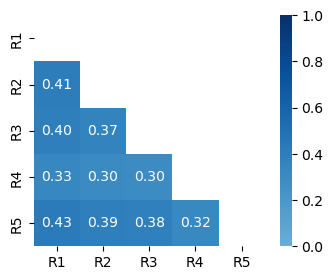

Size+aspect


21/08/2023 17:42:38  observed disagreement: 0.2040588138925397
21/08/2023 17:42:38  expected disagreement: 0.3856479357798165
21/08/2023 17:42:38  observed disagreement: 0.21560498528647268
21/08/2023 17:42:39  expected disagreement: 0.38926259304137095
21/08/2023 17:42:39  observed disagreement: 0.2597285932721616
21/08/2023 17:42:39  expected disagreement: 0.4034690366972477
21/08/2023 17:42:39  observed disagreement: 0.20574923547400029
21/08/2023 17:42:40  expected disagreement: 0.3891131498470948
21/08/2023 17:42:40  observed disagreement: 0.22981805929920052
21/08/2023 17:42:40  expected disagreement: 0.38785966981132075
21/08/2023 17:42:40  observed disagreement: 0.2716424851190595
21/08/2023 17:42:41  expected disagreement: 0.40224609375
21/08/2023 17:42:41  observed disagreement: 0.22110119047620158
21/08/2023 17:42:41  expected disagreement: 0.3877083333333333
21/08/2023 17:42:41  observed disagreement: 0.2808176100628911
21/08/2023 17:42:42  expected disagreement: 0.40533608

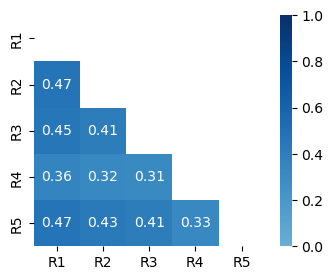

In [19]:
repetition1.name = "Repetition 1"
repetition2.name = "Repetition 2"
repetition3.name = "Repetition 3"
repetition4.name = "Repetition 4"
repetition5.name = "Repetition 5"

for cls in classifs:
    print(cls)
    combs = combinations([repetition1, repetition2, repetition3, repetition4, repetition5], 2)
    
    xRR_matrix = np.ones((5, 5), dtype = float)

    for comb in list(combs):
        xRR_object = xRR(comb[0], comb[1], cls, "Rater", "ItemId")
        #print("xRR score between " + comb[0].name + " and " + comb[1].name + " is:", xRR_object.kappa_x())
        xRR_matrix[int(comb[1].name[-1]) - 1, int(comb[0].name[-1]) - 1] = xRR_object.kappa_x()

    #print("xRR scores for the label ", cls, ": ", xRR_matrix)
    
    columns = ["R1", "R2", "R3", "R4", "R5"]

    df_data = pd.DataFrame(xRR_matrix, columns = columns)

    # Create a mask
    mask = np.triu(np.ones_like(df_data, dtype=bool))

    plt.figure(figsize=(4, 3))
    sns.heatmap(df_data, mask=mask, center=0, annot=True,
                fmt='.2f', square=True, cmap="Blues", yticklabels=["R1", "R2", "R3", "R4", "R5"], 
                vmin=0.0, vmax=1.0)

    plt.show()


# Power Analysis

In [20]:
#Functions used to generate sets of workers per item

def get_uniq_unit_ids(df):
    unique_unit_ids = list(df)
    return unique_unit_ids	

def get_no_work_unit_id(df):
    subset_unit_id = df
    return (len(subset_unit_id), subset_unit_id)

def count_bits(number, n_bits):
    ret = 0
    bit_pos = []
    for i in range(0, n_bits):
        if (1 << i) & number != 0:
            ret += 1
            bit_pos.append(i)
    return (ret, bit_pos)

def gen_all_k_combinations(k, num_size):
    result = []
    for i in range(1, 2**num_size):
        bit_count, bit_pos = count_bits(i, num_size)
        if bit_count == k:
            result.append(bit_pos)
    return result

def gen_all_worker_combinations(subset_size, count, subset_unit_id):
    combinations = gen_all_k_combinations(subset_size, count)
    print(combinations)
    final_result = []
    for comb in combinations:
        crnt_workers = []
        for j in range(0, len(comb)):
            crnt_workers.append(subset_unit_id.loc[comb[j]])
        final_result.append(crnt_workers)
    return final_result

def get_all_unit_combinations(unit_dict):
    sorted_unit_dict = sorted(unit_dict)
    combinations = it.product(*(unit_dict[unit_id] for unit_id in sorted_unit_dict))
    #print(list(combinations))

def my_product(dicts):
    units, comb_of_workers = zip(*dicts.items())
    return [dict(zip(units, x)) for x in it.product(*comb_of_workers)]

def pick_random_worker_set(worker_sets):
    return random.choice(worker_sets)


In [21]:
# Running this cell takes a considerable amount of time; To continue the analysis, move to the next cell;
# Bootstrap experiments - experiment with the number of raters per item
import statistics as sts

def bootstrap_experiments(repetition, repetitionId):
    unique_unit_ids = get_uniq_unit_ids(rep1)

    alpha_values = {}
    mean_values = {}
    stdev_values = {}
    variance_values = {}

    columns_df = ["No Workers"]
    columns_df.extend(["Run %s" % i for i in range(1,101)])
    columns_df.extend(["Mean", "Stdev", "Variance", "Median", "Min", "Max"])

    missing = "*"

    with open('../data/bootstrap_workers_IRR_PR_' + repetitionId + '.csv','w') as f:
        writer = csv.writer(f)
        writer.writerow(columns_df)

    for subset_size in range(3, len(list(set(rep1["Rater"])))):  
        #print(subset_size)  
        row_df = [subset_size]
        alpha_values[subset_size] = []
        mean_values[subset_size] = 0.0
        stdev_values[subset_size] = 0.0
        variance_values[subset_size] = 0.0

        for i in range(100):
            list_w = random.sample(list(set(rep1["Rater"])), subset_size)
  
            current_comb = []

            for item in list_w:
                subset = rep1[rep1["Rater"] == item] 
                current_comb.append(list(subset["Classification"]))

            alpha = krippendorff_alpha(current_comb, metric=nominal_metric, missing_items=missing)
            alpha_values[subset_size].append(alpha)
            row_df.append(alpha)

        mean_values[subset_size] = sum(alpha_values[subset_size])/len(alpha_values[subset_size])
        stdev_values[subset_size] = sts.stdev(alpha_values[subset_size])
        variance_values[subset_size] = sts.variance(alpha_values[subset_size])

        row_df.append(mean_values[subset_size])
        row_df.append(stdev_values[subset_size])
        row_df.append(variance_values[subset_size])

        with open('../data/bootstrap_workers_IRR_PR_' + repetitionId + '.csv','w') as f:
            writer = csv.writer(f)
            writer.writerow(row_df)

#uncomment these lines if you want to run the cell
#bootstrap_experiments(repetition1, 'rep1')
#bootstrap_experiments(repetition2, 'rep2')
#bootstrap_experiments(repetition3, 'rep3')
#bootstrap_experiments(repetition4, 'rep4')
#bootstrap_experiments(repetition5, 'rep5')



In [22]:
#chi-square test for the variance (H0: sigma < sigma_0)

#H0: sigma >= 0.01
#Ha: sigma < 0.01
# large values of chi square give us evidence against the null hypothesis
link1 = '../data/bootstrap_workers_IRR_PR_rep1.csv'
link2 = '../data/bootstrap_workers_IRR_PR_rep2.csv'
link3 = '../data/bootstrap_workers_IRR_PR_rep3.csv'
link4 = '../data/bootstrap_workers_IRR_PR_rep4.csv'
link5 = '../data/bootstrap_workers_IRR_PR_rep5.csv'

bootstrap1 = pd.read_csv(link1)
bootstrap2 = pd.read_csv(link2)
bootstrap3 = pd.read_csv(link3)
bootstrap4 = pd.read_csv(link4)
bootstrap5 = pd.read_csv(link5)

def power_analysis(repetition):
    for i in range(len(repetition)):

        N = 100 #numnber of samples
        values = repetition.iloc[i,1:101]
        s = statistics.stdev(values) 
        delta = 0.01

        chi_square = (N - 1) * s * s / (delta * delta)
        dof = N - 1
        alpha = 0.05

        from scipy.stats import chi2
        p_value = 1 - stats.chi2.cdf(chi_square, dof)

        if p_value >= alpha:
            print("reject the null hypothesis for ", repetition["No Workers"].iloc[i], p_value)
        else:
            print("do not reject the null hypothesis for", repetition["No Workers"].iloc[i], p_value)


In [23]:
print("\nRepetition 1:")
power_analysis(bootstrap1)

print("\nRepetition 2:")
power_analysis(bootstrap2)

print("\nRepetition 3:")
power_analysis(bootstrap3)

print("\nRepetition 4:")
power_analysis(bootstrap4)

print("\nRepetition 5:")
power_analysis(bootstrap5)


Repetition 1:
do not reject the null hypothesis for 3 0.0
do not reject the null hypothesis for 4 0.0
do not reject the null hypothesis for 5 0.0
do not reject the null hypothesis for 6 0.0
do not reject the null hypothesis for 7 0.0
do not reject the null hypothesis for 8 0.0
do not reject the null hypothesis for 9 0.0
do not reject the null hypothesis for 10 0.0
do not reject the null hypothesis for 11 0.0
do not reject the null hypothesis for 12 0.0
do not reject the null hypothesis for 13 0.0
do not reject the null hypothesis for 14 0.0
do not reject the null hypothesis for 15 0.0
do not reject the null hypothesis for 16 0.0
do not reject the null hypothesis for 17 0.0
do not reject the null hypothesis for 18 0.0
do not reject the null hypothesis for 19 0.0
do not reject the null hypothesis for 20 0.0
do not reject the null hypothesis for 21 0.0
do not reject the null hypothesis for 22 0.0
do not reject the null hypothesis for 23 0.0
do not reject the null hypothesis for 24 0.0
do

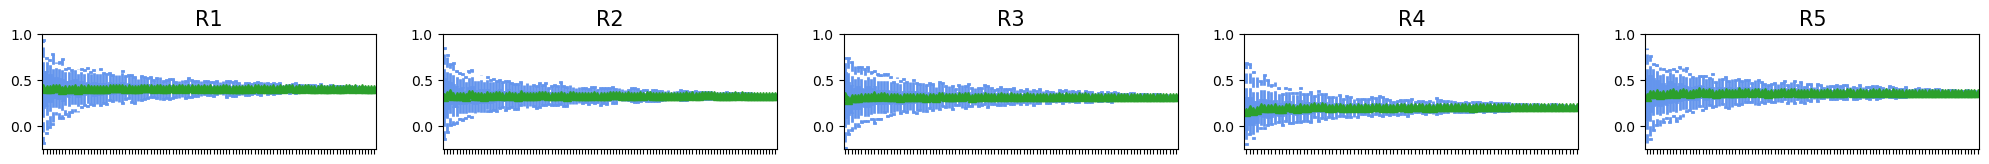

In [24]:
#@title plot the alpha values for every number of workers (in experiment 1)
def data_to_plot(dataframe):
    labels = list(dataframe["No Workers"])

    data = []
    for i in range(len(dataframe)):
        data.append(list(dataframe.iloc[i,1:101]))
    
    return labels, data

def draw_boxplots(ax, data_to_plot, labels, title_text):
    bp = ax.boxplot(data_to_plot, showmeans=True, patch_artist=True, showfliers=False)

      ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='cornflowerblue', linewidth=2)
        # change fill color
        box.set( facecolor = 'white' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='cornflowerblue', linewidth=2,linestyle='--')

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='cornflowerblue', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='white', linewidth=0)
      
    ## change color and linewidth of the means
    for mean in bp['means']:
        mean.set(color='red')

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='blue', alpha=0.5)
      
    ## Custom x-axis labels
    ax.set_xticklabels([])
    ax.set_ylim([-0.25,1])
    ax.get_yaxis().tick_left()
    ax.set_title(title_text, fontsize=15)


link1 = '../data/bootstrap_workers_IRR_PR_rep1.csv'
link2 = '../data/bootstrap_workers_IRR_PR_rep2.csv'
link3 = '../data/bootstrap_workers_IRR_PR_rep3.csv'
link4 = '../data/bootstrap_workers_IRR_PR_rep4.csv'
link5 = '../data/bootstrap_workers_IRR_PR_rep5.csv'

bootstrap1 = pd.read_csv(link1)
bootstrap2 = pd.read_csv(link2)
bootstrap3 = pd.read_csv(link3)
bootstrap4 = pd.read_csv(link4)
bootstrap5 = pd.read_csv(link5)

fig = plt.figure(1, figsize=(25, 1.5))

ax = fig.add_subplot(151)
labels, data = data_to_plot(bootstrap1)
draw_boxplots(ax, data, labels, "R1")

ax = fig.add_subplot(152)
labels, data = data_to_plot(bootstrap2)
draw_boxplots(ax, data, labels, "R2")

ax = fig.add_subplot(153)
labels, data = data_to_plot(bootstrap3)
draw_boxplots(ax, data, labels, "R3")

ax = fig.add_subplot(154)
labels, data = data_to_plot(bootstrap4)
draw_boxplots(ax, data, labels, "R4")

ax = fig.add_subplot(155)
labels, data = data_to_plot(bootstrap5)
draw_boxplots(ax, data, labels, "R5")


fig.savefig("../plots/bootstrap_workers_replications_PR.png",  bbox_inches='tight', format='png', dpi=1200)